In [1]:

import os
import torch
import numpy as np
import torch.utils.data
from PIL import Image
 
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
 
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance with 0 being background
        mask = Image.open(mask_path)
 
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
 
        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]
 
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [2]:
#定义模型

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
 
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
 
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
 
    return model

In [3]:
#数据增强

import utils
import transforms as T


from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
     

In [4]:


# use the PennFudan dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed_test', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed_test', get_transform(train=True))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
 
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)
 
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)
 
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
 
# the dataset has two classes only - background and person
num_classes = 8
 
# get the model using the helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)
 
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
 
# the learning rate scheduler decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
 
# training
num_epochs = 20
for epoch in range(num_epochs):
    print(epoch)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
 
    # update the learning rate
    lr_scheduler.step()
 
    # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)



C:\Users\10369\.conda\envs\rcnn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\10369\.conda\envs\rcnn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
Epoch: [0]  [ 0/11]  eta: 0:00:45  lr: 0.000504  loss: 4.4378 (4.4378)  loss_classifier: 1.9116 (1.9116)  loss_box_reg: 0.3222 (0.3222)  loss_mask: 1.7410 (1.7410)  loss_objectness: 0.4061 (0.4061)  loss_rpn_box_reg: 0.0569 (0.0569)  time: 4.1039  data: 0.4131  max mem: 3806
Epoch: [0]  [ 1/11]  eta: 0:00:26  lr: 0.001004  loss: 3.4483 (3.9430)  loss_classifier: 1.7644 (1.8380)  loss_box_reg: 0.2240 (0.2731)  loss_mask: 1.3330 (1.5370)  loss_objectness: 0.0740 (0.2400)  loss_rpn_box_reg: 0.0530 (0.0549)  time: 2.6013  data: 0.3969  max mem: 3969
Epoch: [0]  [ 2/11]  eta: 0:00:19  lr: 0.001504  loss: 3.4483 (3.6148)  loss_classifier: 1.7644 (1.7476)  loss_box_reg: 0.2496 (0.2653)  loss_mask: 1.3330 (1.3609)  loss_objectness: 0.0879 (0.1893)  loss_rpn_box_reg: 0.0530 (0.0517)  time: 2.1151  data: 0.4073  max mem: 3972
Epoch: [0]  [ 3/11]  eta: 0:00:14  lr: 0.002003  loss: 2.9584 (3.3343)  loss_classifier: 1.5670 (1.5678)  loss_box_reg: 0.2408 (0.2591)  loss_mask: 1.0101 (1.2732)  loss_

IndexError: too many indices for tensor of dimension 1

In [5]:

# 模型保存
torch.save(model, 'model/model.pkl')


In [6]:
# 模型加载
model = torch.load('model/model.pkl')

In [7]:
###展示模型效果
from PIL import Image
# pick one image from the test set
img, _ = dataset_test[4]
 
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])


In [10]:
img

tensor([[[0.2471, 0.2196, 0.1961,  ..., 0.1725, 0.2039, 0.1922],
         [0.1765, 0.1725, 0.1804,  ..., 0.1961, 0.1961, 0.2039],
         [0.2157, 0.2118, 0.2157,  ..., 0.2157, 0.1765, 0.2078],
         ...,
         [0.7137, 0.7098, 0.7020,  ..., 0.7765, 0.8078, 0.7725],
         [0.7216, 0.7137, 0.7020,  ..., 0.7451, 0.7686, 0.7333],
         [0.6745, 0.6745, 0.6706,  ..., 0.7098, 0.7098, 0.6824]],

        [[0.2588, 0.2314, 0.2039,  ..., 0.1686, 0.1882, 0.1765],
         [0.1882, 0.1843, 0.1882,  ..., 0.1922, 0.1804, 0.1882],
         [0.2275, 0.2235, 0.2235,  ..., 0.2118, 0.1608, 0.1922],
         ...,
         [0.7176, 0.7137, 0.7059,  ..., 0.7765, 0.8078, 0.7725],
         [0.7255, 0.7176, 0.7059,  ..., 0.7451, 0.7686, 0.7333],
         [0.6784, 0.6784, 0.6745,  ..., 0.7098, 0.7098, 0.6824]],

        [[0.2235, 0.1961, 0.1843,  ..., 0.1608, 0.1765, 0.1647],
         [0.1529, 0.1490, 0.1686,  ..., 0.1843, 0.1686, 0.1765],
         [0.1922, 0.1882, 0.2039,  ..., 0.2039, 0.1490, 0.

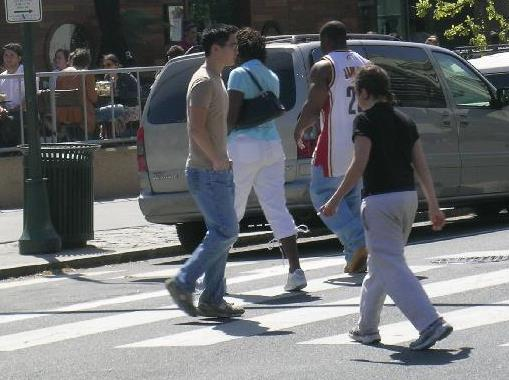

In [58]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

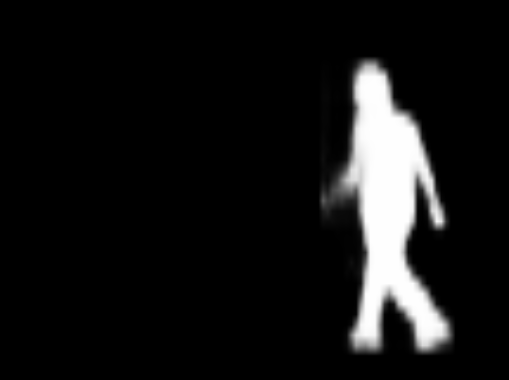

In [59]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [31]:
prediction

[{'boxes': tensor([[207.2837,  22.7322, 336.2510, 332.5191],
          [ 45.8470,  56.2072, 187.5025, 328.5980],
          [128.9512,  24.1594, 301.8051, 332.4304]], device='cuda:0'),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9968, 0.9967, 0.0873], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ...,

In [30]:
prediction[0]['masks'].shape

torch.Size([3, 1, 348, 473])

In [35]:
masks = prediction[0]['masks'].reshape(3,348,473)

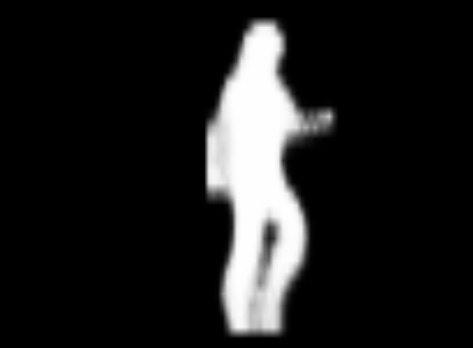

In [43]:
Image.fromarray(masks[0].mul(255).byte().cpu().numpy())

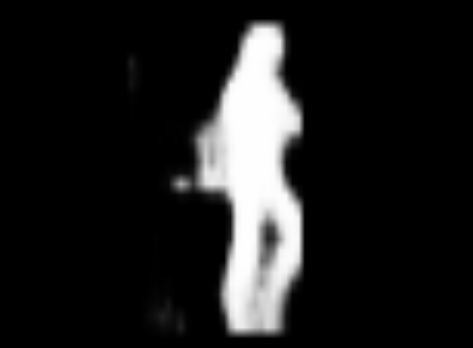

In [51]:
Image.fromarray(masks[2].mul(255).byte().cpu().numpy())

In [44]:
###进行非极大值抑制
import torchvision.ops as ops
boxes = prediction[0]['boxes']
scores = prediction[0]['scores']
boxes.shape,scores.shape

(torch.Size([3, 4]), torch.Size([3]))

In [52]:
keep_idx = ops.nms(boxes, scores, iou_threshold=0.3)
filtered_masks = masks[keep_idx]

In [55]:
len(filtered_masks),len(masks),keep_idx.cpu().numpy()

(2, 3, array([0, 1], dtype=int64))